# Import Data

In [1]:
import pandas as pd

train_df = pd.read_csv('../../input/feedback-prize-effectiveness/train.csv')
stack_df = pd.read_csv('../../99_Ensemble/99_v1_02/result/stack_99_v1_02_06.csv')

train_df = train_df[['discourse_id']].merge(stack_df, on='discourse_id', how='left')
print(train_df.shape)
train_df.head()

(36765, 25)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,Ineffective_0,Adequate_0,Effective_0,label,loss,...,Effective_2,Ineffective_3,Adequate_3,Effective_3,Ineffective_4,Adequate_4,Effective_4,Ineffective,Adequate,Effective
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0.004596,0.128424,0.009837,1,0.106507,...,0.019735,0.009225,0.264238,0.012251,0.001000,0.116014,0.025843,0.005753,0.179938,0.014309
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,0.014678,0.126776,0.001403,1,0.119425,...,0.007895,0.014992,0.263233,0.007489,0.010160,0.126896,0.005801,0.012774,0.182200,0.005025
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,0.039009,0.103240,0.000608,1,0.324790,...,0.003183,0.072405,0.210553,0.002757,0.010405,0.127156,0.005296,0.038410,0.159011,0.002580
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0.029824,0.111454,0.001580,1,0.248233,...,0.002466,0.068198,0.214155,0.003361,0.036436,0.102802,0.003619,0.051634,0.145836,0.002530
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0.044976,0.097321,0.000560,1,0.383832,...,0.001205,0.098344,0.185625,0.001745,0.023646,0.115180,0.004031,0.059501,0.138864,0.001635


# Features

# Data Split

In [2]:
from os.path import join as opj

class args:
    fold_path = '../../00_EDA/00_v2_07/result/'
    num_fold = 5
    
fold_path = args.fold_path
import joblib
print('load folds...')
trn_ids_list = joblib.load(opj(fold_path,f'trn_ids_list.joblib'))
val_ids_list = joblib.load(opj(fold_path,f'val_ids_list.joblib'))

load folds...


# Stacking

In [3]:
import matplotlib.pyplot as plt

def show_feature_importance(model):
    feature_importance = model.get_feature_importance()
    fi_df = pd.DataFrame({'importance':feature_importance, 'features':cols})
    fi_df = fi_df.sort_values('importance', ascending=True)

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(fi_df)),
            fi_df['importance'].values,
            tick_label=fi_df['features'].values)
    plt.xlabel('importance')
    plt.ylabel('features')
    plt.grid()
    plt.show()

In [4]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_df['discourse_type_label'] = le.fit_transform(train_df['discourse_type'])

In [5]:
cols = []
for col_name in ['Ineffective','Adequate','Effective']:
    cols += [col for col in train_df.columns if (col.startswith(col_name) and '_' in col)] 
    
num_models = len(cols) // 3
num_models

5

In [7]:
import catboost
params = {
    'random_state':45, 
    'n_estimators':20000,
    'loss_function':'MultiClass',
    #'eval_metric':'MultiClass'
}

fold0 : CV=0.5805


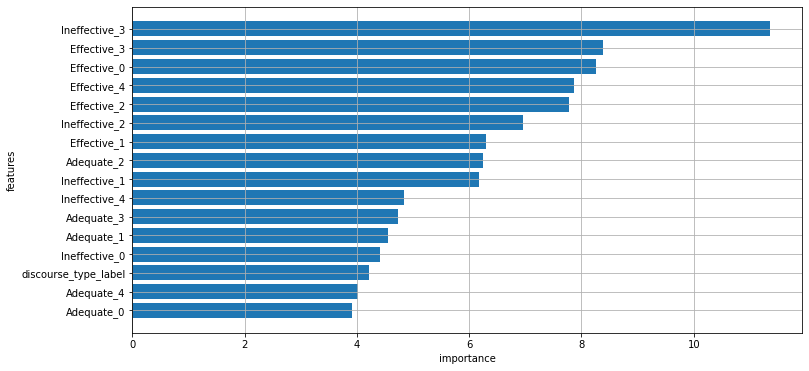

fold1 : CV=0.5968


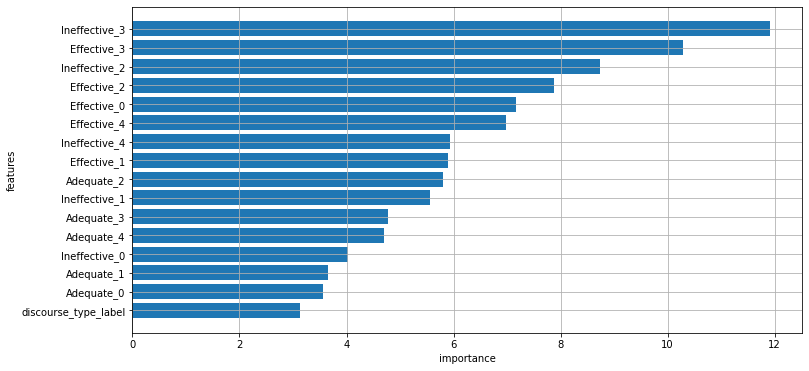

fold2 : CV=0.5791


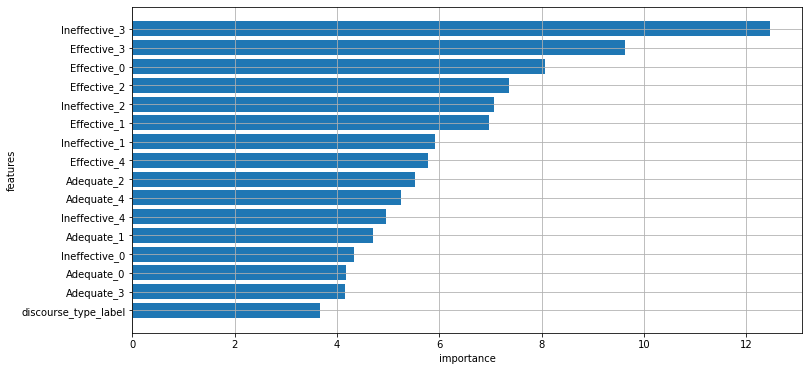

fold3 : CV=0.6028


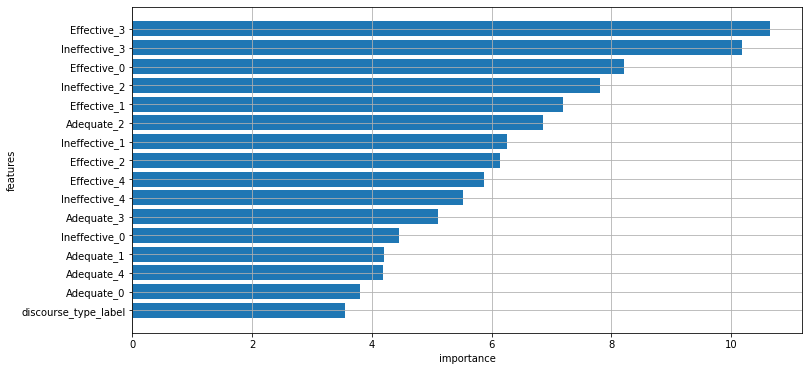

fold4 : CV=0.5907


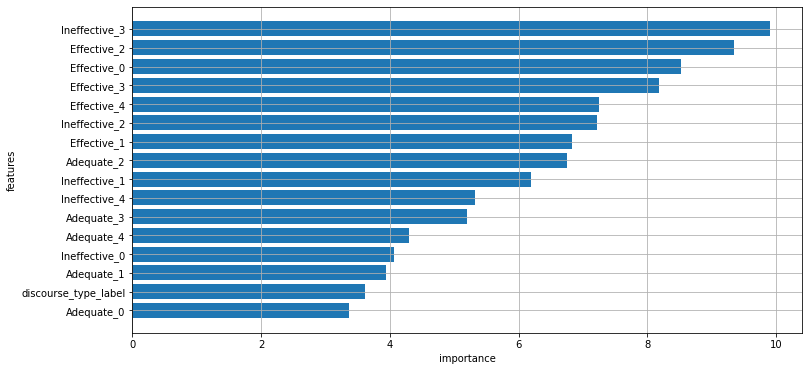

CV=0.5900


In [8]:
from sklearn.metrics import log_loss
import pickle
import os
os.makedirs('./result', exist_ok=True)

cols = cols + ['discourse_type_label']

score_list = []
oof_df = []
for fold in range(args.num_fold):
    trn_df = train_df[train_df['essay_id'].isin(trn_ids_list[fold])].reset_index(drop=True)
    val_df = train_df[train_df['essay_id'].isin(val_ids_list[fold])].reset_index(drop=True)

    model = catboost.CatBoostClassifier(**params)
    model.fit(trn_df[cols].values, 
              trn_df['label'].values ,
              eval_set=[(val_df[cols].values, val_df['label'].values)], 
              verbose=0, 
              early_stopping_rounds=100,
              #cat_features=[num_models]
             )

    pred = model.predict(val_df[cols].values, prediction_type='Probability')
    target = val_df['label'].values
    score = log_loss(target, pred, labels=[0,1,2])
    print('fold{} : CV={:.4f}'.format(fold, score))
    score_list.append(score)
    val_df['oof_ineffective'] = pred[:,0]
    val_df['oof_adequate'] = pred[:,1]
    val_df['oof_effective'] = pred[:,2]
    oof_df.append(val_df)
    # save model
    joblib.dump(model, f'./result/cat_fold{fold}.joblib')
    # plot
    show_feature_importance(model)
    
CV = sum(score_list) / len(score_list)
print('CV={:.4f}'.format(CV))

In [11]:
joblib.dump(le, f'./result/label_encoder.joblib')

['./result/label_encoder.joblib']

In [9]:
oof_df = pd.concat(oof_df).reset_index(drop=True)
oof_df = train_df[['discourse_id']].merge(oof_df, on='discourse_id', how='left')
oof_df.to_csv(f'./result/oof_cat.csv', index=False)
print(oof_df.shape)
oof_df.head()

(36765, 29)


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,Ineffective_0,Adequate_0,Effective_0,label,loss,...,Ineffective_4,Adequate_4,Effective_4,Ineffective,Adequate,Effective,discourse_type_label,oof_ineffective,oof_adequate,oof_effective
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,0.004596,0.128424,0.009837,1,0.106507,...,0.001000,0.116014,0.025843,0.005753,0.179938,0.014309,4,0.033619,0.878421,0.087960
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,0.014678,0.126776,0.001403,1,0.119425,...,0.010160,0.126896,0.005801,0.012774,0.182200,0.005025,5,0.084950,0.882559,0.032491
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform be...,Claim,Adequate,0.039009,0.103240,0.000608,1,0.324790,...,0.010405,0.127156,0.005296,0.038410,0.159011,0.002580,0,0.220201,0.767598,0.012201
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The...",Evidence,Adequate,0.029824,0.111454,0.001580,1,0.248233,...,0.036436,0.102802,0.003619,0.051634,0.145836,0.002530,3,0.323940,0.664285,0.011774
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by ali...,Counterclaim,Adequate,0.044976,0.097321,0.000560,1,0.383832,...,0.023646,0.115180,0.004031,0.059501,0.138864,0.001635,2,0.321644,0.673718,0.004638


In [10]:
cols = [col for col in oof_df.columns if col.startswith('oof_')]

oof_score = log_loss(oof_df['label'].values, oof_df[cols].values, labels=[0,1,2])
print('oof={:.4f}'.format(oof_score))

oof=0.5901
